In [154]:
import tqdm
import pickle
import random
import xgboost
import itertools
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm

import xgboost as xgb
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, precision_recall_curve, auc, roc_curve

plt.style.use("jupyter")

In [2]:
dm = pd.read_csv("../data/iza_dm.csv", index_col=0)
synth = pd.read_csv("../data/synthesis_fraction.csv", index_col=0)
synth = synth.loc[dm.index]

feat = pd.read_csv("../data/zeo-features.csv", index_col=0)

In [191]:
TEST_SIZE = 0.3
RANDOM_SEED = 42

def get_metrics(y_true, y_pred, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    pr, rc, _ = pr_curve = precision_recall_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    pr_auc = auc(rc, pr)

    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "F1-score": f1_score(y_true, y_pred),
        "fpr": fpr,
        "tpr": tpr,
        "pr": pr,
        "rc": rc,
        "roc_auc": roc_auc,
    }    

def get_datasets(X: np.ndarray, y: np.ndarray, test_size: float = TEST_SIZE, balanced: bool = True, random_seed=RANDOM_SEED):
    n_pos = y.sum()
    n_neg = (~y).sum()
    
    _X = X - 0.45
    # Creating the datasets
    X_pos, y_pos = X.loc[y], y.loc[y]
    X_neg, y_neg = X.loc[~y], y.loc[~y]
    
    # Creating balanced datasets: subsample the negative data
    # to make the positive and negative data compatible
    if balanced:
        i = np.arange(n_neg)
        i_neg = np.random.choice(i, n_pos)
        X_neg, y_neg = X_neg.iloc[i_neg], y_neg.iloc[i_neg]

    # Use the same number of positive-negative points in the train/test sets
    X_train_pos, X_test_pos, y_train_pos, y_test_pos = train_test_split(X_pos, y_pos, test_size=test_size, random_state=random_seed)
    X_train_neg, X_test_neg, y_train_neg, y_test_neg = train_test_split(X_neg, y_neg, test_size=test_size, random_state=random_seed)
    
    # concatenate the datasets
    concat_fn = pd.concat if isinstance(X, pd.DataFrame) else np.concatenate
    
    X_train = concat_fn([X_train_pos, X_train_neg])
    X_test = concat_fn([X_test_pos, X_test_neg])
    y_train = concat_fn([y_train_pos, y_train_neg]).astype(int)
    y_test = concat_fn([y_test_pos, y_test_neg]).astype(int)
    
    return X_train, X_test, y_train, y_test

## Training a balanced classifier

In [192]:
clf = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
)

results = []
_LABELS = synth.columns
THRESHOLD = 0.25
MINIMUM_POSITIVE = 10

for _label in tqdm.notebook.tqdm(_LABELS):
    # Get the information for the dataset
    X = dm
    y = (synth[_label] > THRESHOLD)
    
    n_pos = y.sum()

    if n_pos <= MINIMUM_POSITIVE:
        continue
    
    X_train, X_test, y_train, y_test = get_datasets(X, y, balanced=True)

    # Fitting the classifier
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_score = clf.predict_proba(X_test)[:, 1]

    results.append({
        "label": _label,
        "classifier": type(clf).__name__,
        "y_test": y_test,
        "y_pred": y_pred,
        "n_pos": y_train.sum(),
        "n_neg": (1 - y_train).sum(),
        **get_metrics(y_test, y_pred, y_score),
    })

results_df = pd.DataFrame(results)

  0%|          | 0/38 [00:00<?, ?it/s]

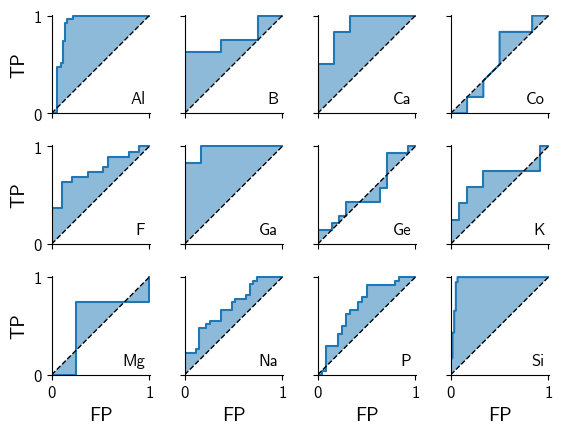

In [193]:
LX, LY = 1.5, 1.5
fig, ax_fig = plt.subplots(3, 4, figsize=(4 * LX, 3 * LY), sharex=True, sharey=True)

for ax, label in zip(ax_fig.reshape(-1), results_df["label"].unique()):
    _df = results_df.loc[results_df.label == label]
    
    _x = _df["fpr"].item()
    _y = _df["tpr"].item()
    random = np.linspace(0, 1, len(_x))
    
    ax.plot(_x, _y)
    ax.plot(_x, _x, linestyle="--", color="k", linewidth=1)
    ax.fill_between(
        _x,
        _y,
        _x,
        alpha=0.5,
        interpolate=True,
    )

    ax.set_xlim(0, 1.01)
    ax.set_ylim(0, 1.01)
#     ax.set_xlabel("FP")
#     ax.set_ylabel("TP")
    ax.annotate(label, (0.95, 0.1), xycoords="axes fraction", ha='right')

    ax.set_aspect("equal")

for ax in ax_fig[-1, :]:
    ax.set_xlabel("FP")

for ax in ax_fig[:, 0]:
    ax.set_ylabel("TP")
    
    
fig.tight_layout()

plt.show()

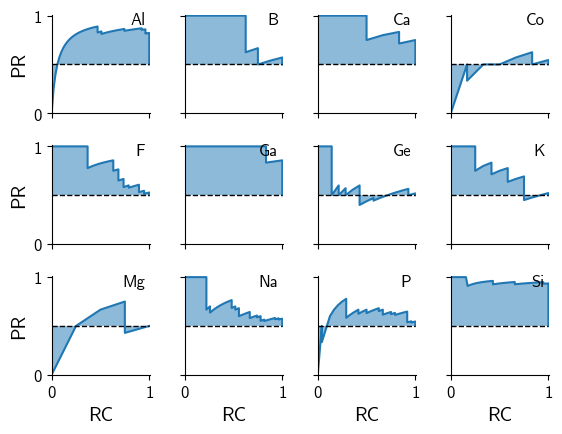

In [194]:
LX, LY = 1.5, 1.5
fig, ax_fig = plt.subplots(3, 4, figsize=(4 * LX, 3 * LY), sharex=True, sharey=True)

for ax, label in zip(ax_fig.reshape(-1), results_df["label"].unique()):
    _df = results_df.loc[results_df.label == label]
    
    _x = _df["rc"].item()
    _y = _df["pr"].item()
    
    baseline = _df["n_pos"] / (_df["n_pos"] + _df["n_neg"])
    
    ax.plot(_x, _y)
    ax.plot([0, 1], [baseline, baseline], linestyle="--", color="k", linewidth=1)
    ax.fill_between(
        _x,
        _y,
        baseline,
        alpha=0.5,
        interpolate=True,
    )

    ax.set_xlim(0, 1.01)
    ax.set_ylim(0, 1.01)
    ax.annotate(label, (0.95, 0.9), xycoords="axes fraction", ha='right')

    ax.set_aspect("equal")

for ax in ax_fig[-1, :]:
    ax.set_xlabel("RC")

for ax in ax_fig[:, 0]:
    ax.set_ylabel("PR")
    
    
fig.tight_layout()

plt.show()

In [195]:
results_df[["label", "accuracy", "precision", "recall", "F1-score", "roc_auc"]]

,label,accuracy,precision,recall,F1-score,roc_auc
0,Al,0.813725,0.863636,0.745098,0.800000,0.901961
1,B,0.625000,0.600000,0.750000,0.666667,0.765625
2,Ca,0.750000,0.714286,0.833333,0.769231,0.888889
3,Co,0.666667,0.625000,0.833333,0.714286,0.541667
4,F,0.736842,0.764706,0.684211,0.722222,0.764543
5,Ga,0.833333,0.833333,0.833333,0.833333,0.972222
6,Ge,0.428571,0.428571,0.428571,0.428571,0.520408
7,K,0.625000,0.600000,0.750000,0.666667,0.673611
8,Mg,0.500000,0.500000,0.750000,0.600000,0.562500
9,Na,0.629630,0.629630,0.629630,0.629630,0.698217


## Training an imbalanced classifier

In [196]:
clf = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
)

results = []
_LABELS = synth.columns
THRESHOLD = 0.25
MINIMUM_POSITIVE = 10

for _label in tqdm.notebook.tqdm(_LABELS):
    # Get the information for the dataset
    X = dm
    y = (synth[_label] > THRESHOLD)
    
    n_pos = y.sum()

    if n_pos <= MINIMUM_POSITIVE:
        continue
    
    X_train, X_test, y_train, y_test = get_datasets(X, y, balanced=False)

    # Fitting the classifier
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_score = clf.predict_proba(X_test)[:, 1]

    results.append({
        "label": _label,
        "classifier": type(clf).__name__,
        "y_test": y_test,
        "y_pred": y_pred,
        "n_pos": y_train.sum(),
        "n_neg": (1 - y_train).sum(),
        **get_metrics(y_test, y_pred, y_score),
    })

results_df = pd.DataFrame(results)

  0%|          | 0/38 [00:00<?, ?it/s]

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


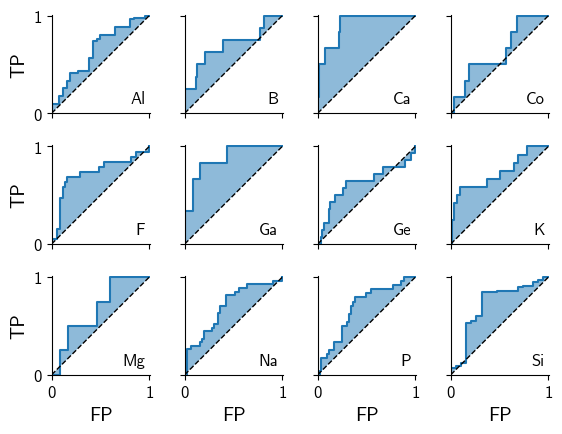

In [197]:
LX, LY = 1.5, 1.5
fig, ax_fig = plt.subplots(3, 4, figsize=(4 * LX, 3 * LY), sharex=True, sharey=True)

for ax, label in zip(ax_fig.reshape(-1), results_df["label"].unique()):
    _df = results_df.loc[results_df.label == label]
    
    _x = _df["fpr"].item()
    _y = _df["tpr"].item()
    
    ax.plot(_x, _y)
    ax.plot(_x, _x, linestyle="--", color="k", linewidth=1)
    ax.fill_between(
        _x,
        _y,
        _x,
        alpha=0.5,
        interpolate=True,
    )

    ax.set_xlim(0, 1.01)
    ax.set_ylim(0, 1.01)
    ax.annotate(label, (0.95, 0.1), xycoords="axes fraction", ha='right')

    ax.set_aspect("equal")

for ax in ax_fig[-1, :]:
    ax.set_xlabel("FP")

for ax in ax_fig[:, 0]:
    ax.set_ylabel("TP")
    
    
fig.tight_layout()

plt.show()

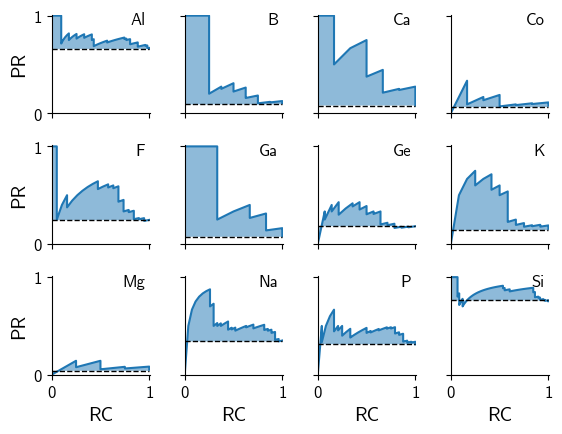

In [198]:
LX, LY = 1.5, 1.5
fig, ax_fig = plt.subplots(3, 4, figsize=(4 * LX, 3 * LY), sharex=True, sharey=True)

for ax, label in zip(ax_fig.reshape(-1), results_df["label"].unique()):
    _df = results_df.loc[results_df.label == label]
    
    _x = _df["rc"].item()
    _y = _df["pr"].item()
    
    baseline = _df["n_pos"] / (_df["n_pos"] + _df["n_neg"])
    
    ax.plot(_x, _y)
    ax.plot([0, 1], [baseline, baseline], linestyle="--", color="k", linewidth=1)
    ax.fill_between(
        _x,
        _y,
        baseline,
        alpha=0.5,
        interpolate=True,
    )

    ax.set_xlim(0, 1.01)
    ax.set_ylim(0, 1.01)
#     ax.set_xlabel("FP")
#     ax.set_ylabel("TP")
    ax.annotate(label, (0.95, 0.9), xycoords="axes fraction", ha='right')

    ax.set_aspect("equal")

for ax in ax_fig[-1, :]:
    ax.set_xlabel("RC")

for ax in ax_fig[:, 0]:
    ax.set_ylabel("PR")
    
    
fig.tight_layout()

plt.show()

In [199]:
results_df[["label", "accuracy", "precision", "recall", "F1-score", "roc_auc"]]

,label,accuracy,precision,recall,F1-score,roc_auc
0,Al,0.701299,0.725806,0.882353,0.796460,0.646305
1,B,0.922078,1.000000,0.250000,0.400000,0.697464
2,Ca,0.934211,0.666667,0.333333,0.444444,0.909524
3,Co,0.909091,0.000000,0.000000,0.000000,0.631455
4,F,0.805195,0.611111,0.578947,0.594595,0.729583
5,Ga,0.935065,0.666667,0.333333,0.444444,0.873239
6,Ge,0.805195,0.400000,0.142857,0.210526,0.622449
7,K,0.857143,0.600000,0.250000,0.352941,0.728205
8,Mg,0.948052,0.000000,0.000000,0.000000,0.671233
9,Na,0.649351,0.500000,0.296296,0.372093,0.698519
